## 1. Importing data

In [15]:
import pandas as pd

In [16]:
df = pd.read_excel("https://github.com/statisticspoland/ecoicop_classification/blob/master/products_allshops_dataset.xlsx?raw=true")

In [17]:
df

,produkt,kategoria
0,"""słynne roślinne""",Margaryna i inne tłuszcze roślinne
1,#Hejki - Emotki lizaki ręcznie robione o smaka...,Wyroby cukiernicze
2,100% Pur jus d'orange - sok pomarańczowy z mią...,Soki owocowe i warzywne
3,100% sukraloza bez cukru (substancje słodzące),Sztuczne substytuty cukru
4,100% z brzoskwiń produkt owocowy słodzony zag....,"Dżemy, marmolady i miód"
...,...,...
16625,Żywiec Zdrój ze smakiem truskawki Napój niegaz...,Wody mineralne lub źródlane
16626,Żywiec green tea&gruszka,Napoje orzeźwiające
16627,Żywioł - Woda źródlana delikatnie gazowana,Wody mineralne lub źródlane
16628,Żywioł - Woda źródlana gazowana,Wody mineralne lub źródlane


## 2. Simulating Data Drift

In [18]:
#Let's introduce order to the dataset by sorting with "produkt" column
df = df.sort_values(by="produkt")

In [19]:
#Now any continuous subset of the data should have different characteristics than the data as a whole. Let's divide the data to "new" and "original" sets. We then compare the sets to determine if the new data has same characteristics as the original data

new_data = df[0:20]
original_data = df[20:len(df)]

In [20]:
#For Data Drift we only consider the "features" (or X -columns), which is the "produkt" column
new_data = new_data[["produkt"]]
original_data = original_data[["produkt"]]

In [21]:
#To detect datadrift we use the Kolmogorov-Smirnov algorithm from the Alibi Detect library
#For algorithm overview, see: https://docs.seldon.io/projects/alibi-detect/en/latest/overview/algorithms.html
#For the algorithm used here, see: https://docs.seldon.io/projects/alibi-detect/en/latest/cd/methods/ksdrift.html

#The algorithm is "trained" with the original data, after which it can be used to detect drift in new data. For p-value we use the standard 0.05.

from alibi_detect.cd import KSDrift
data_drift_detector = KSDrift(original_data.to_numpy(), p_val=0.05)

In [22]:
#Now we "predict" if there is a detectable drift in an incoming "new" data
#Predictions return a dictionary with the information from our predictions.
#The 'is_drift' key has a boolean value which indicates whether there is drift (1) or not (0)
#As we can see, our detector detected drift, as expected. At this point we could send an alert of detected drift to whatever monitoring system we have in place.

predictions = data_drift_detector.predict(new_data.to_numpy(), drift_type="batch", return_p_val=True, return_distance=True)
predictions

{'data': {'is_drift': 1,
  'distance': array([1.], dtype=float32),
  'p_val': array([0.], dtype=float32),
  'threshold': 0.05},
 'meta': {'name': 'KSDrift', 'detector_type': 'offline', 'data_type': None}}

In [35]:
#As a sanity check, let's confirm that drift is not detected when it shouldn't be.
#Let's take an unbiased sample from the original data and run another predictions.
#This sample should have the same characteristics as the original data
#As we can see, we do not detect drift

unbiased_sample = original_data.sample(n=20)
predictions_unbiased = data_drift_detector.predict(unbiased_sample.to_numpy(), drift_type="batch", return_p_val=True, return_distance=True)
predictions_unbiased

{'data': {'is_drift': 0,
  'distance': array([0.21336544], dtype=float32),
  'p_val': array([0.28036776], dtype=float32),
  'threshold': 0.05},
 'meta': {'name': 'KSDrift', 'detector_type': 'offline', 'data_type': None}}

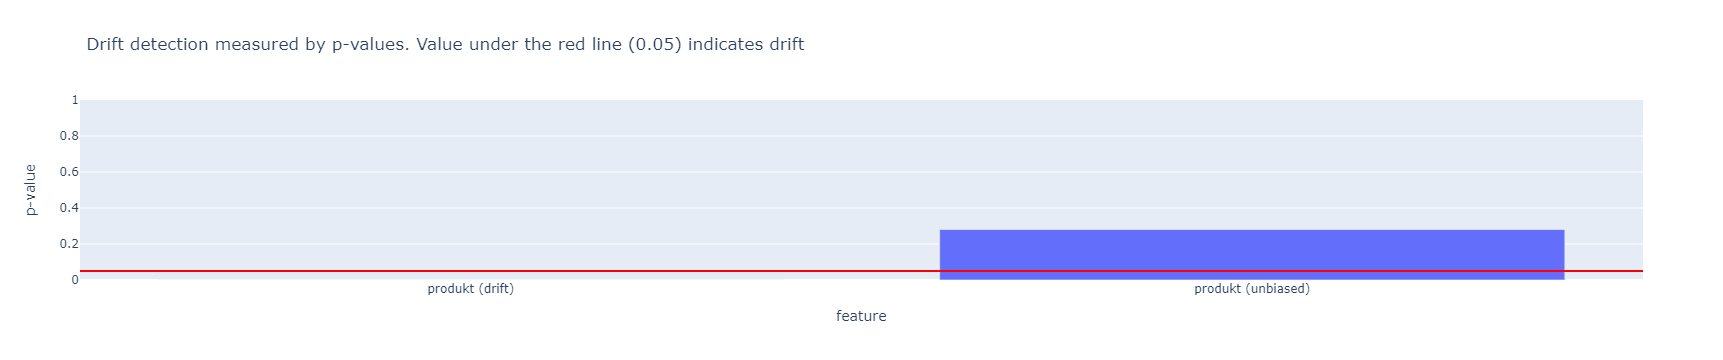

In [36]:
#Let's visualize the drift predictions:
p_values = [predictions["data"]["p_val"][0], predictions_unbiased["data"]["p_val"][0]]
features = ["produkt (drift)", "produkt (unbiased)"]

from plotly import express as px
fig = px.bar({"p-value": p_values, "feature": features}, x="feature", y="p-value", range_y=[0,1], title="Drift detection measured by p-values. Value under the red line (0.05) indicates drift")
fig.add_hline(y=0.05, line_color="red")
fig.show()

## 3. Simulating Concept Drift

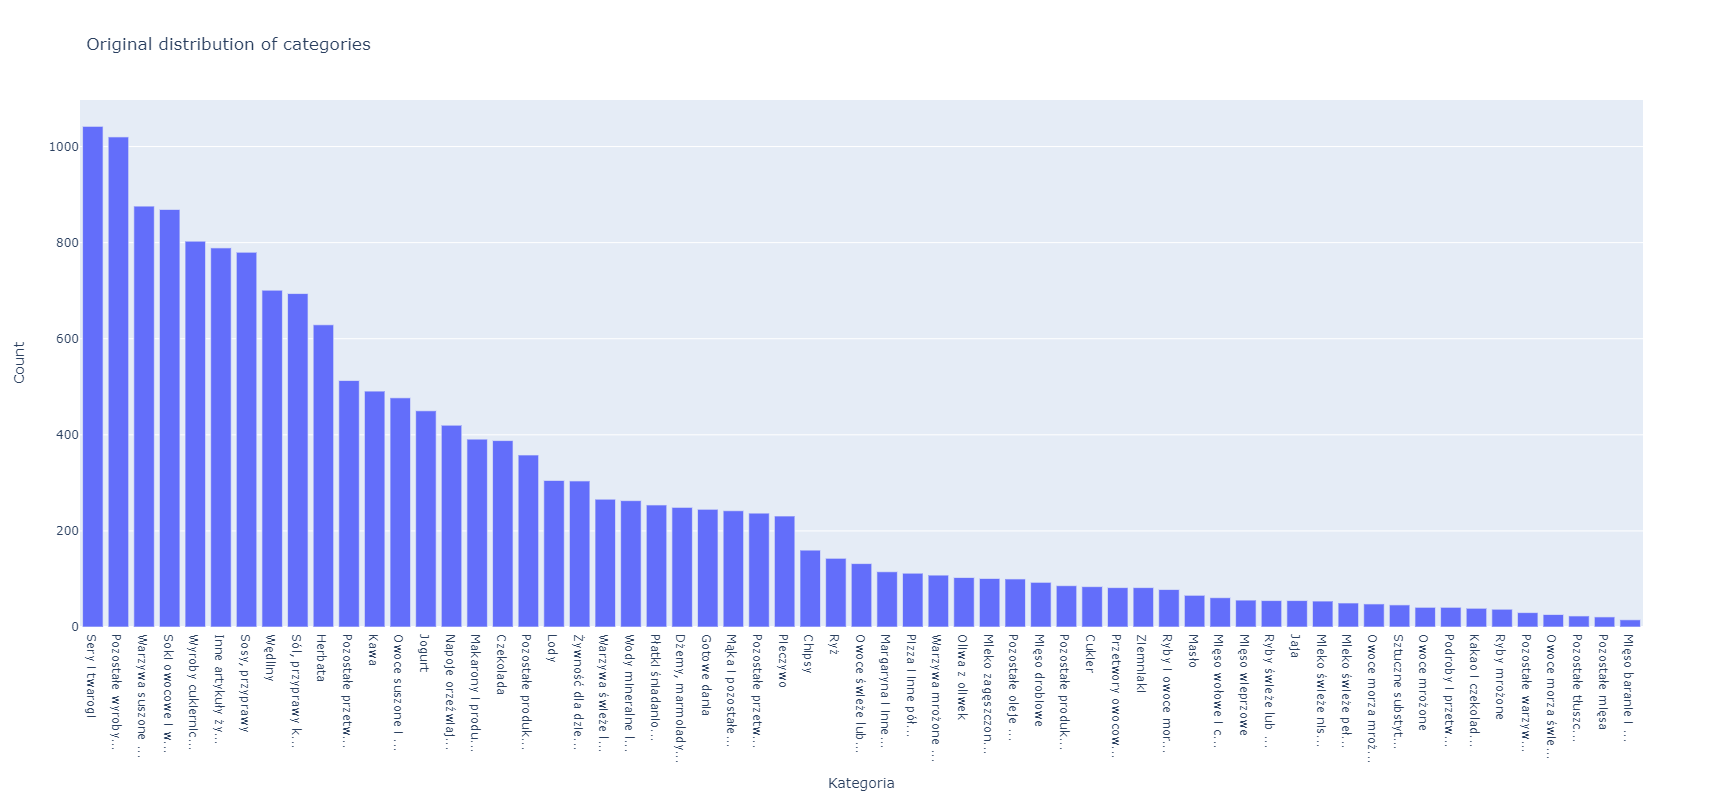

In [26]:
#Let's simulate a change in target variable "kategoria"
#First we visualize the original distribution of categories

fig = px.bar({"Count": df["kategoria"].value_counts().values, "Kategoria": df["kategoria"].value_counts().index}, x="Kategoria", y="Count", title="Original distribution of categories", barmode="group", height=800)

fig.update_xaxes(
  tickvals=df["kategoria"].value_counts().index,
  ticktext=[s if len(s)<16 else s[0:16]+"..." for s in df["kategoria"].value_counts().index]
)

fig.show()

In [30]:
#For simulation purposes let's assume the labeling system changes. So products that used to be in category x are now in y. Let's build data with this alternative system:
import random
categories = df["kategoria"].unique()
int_list = [i for i in range(0, len(categories))]
random.shuffle(int_list)

mapper = {categories[idx]:categories[val] for idx, val in enumerate(int_list)}
df["new kategoria"] = df["kategoria"].map(mapper)

print("Examples of labeling changes:")
i = 0
for key, val in mapper.items():
  print(f"{key} ---> {val}")
  i = i + 1
  if i == 5:
    break

print("")
print("New Category system in the data set:")
df.head()

Examples of labeling changes:
Margaryna i inne tłuszcze roślinne ---> Pozostałe produkty zbożowe
Wyroby cukiernicze ---> Jaja
Soki owocowe i warzywne ---> Mleko świeże niskotłuszczowe
Sztuczne substytuty cukru ---> Jogurt
Dżemy, marmolady i miód ---> Pizza i inne półprodukty mączne

New Category system in the data set:


,produkt,kategoria,new kategoria
0,"""słynne roślinne""",Margaryna i inne tłuszcze roślinne,Pozostałe produkty zbożowe
1,#Hejki - Emotki lizaki ręcznie robione o smaka...,Wyroby cukiernicze,Jaja
2,100% Pur jus d'orange - sok pomarańczowy z mią...,Soki owocowe i warzywne,Mleko świeże niskotłuszczowe
3,100% sukraloza bez cukru (substancje słodzące),Sztuczne substytuty cukru,Jogurt
4,100% z brzoskwiń produkt owocowy słodzony zag....,"Dżemy, marmolady i miód",Pizza i inne półprodukty mączne


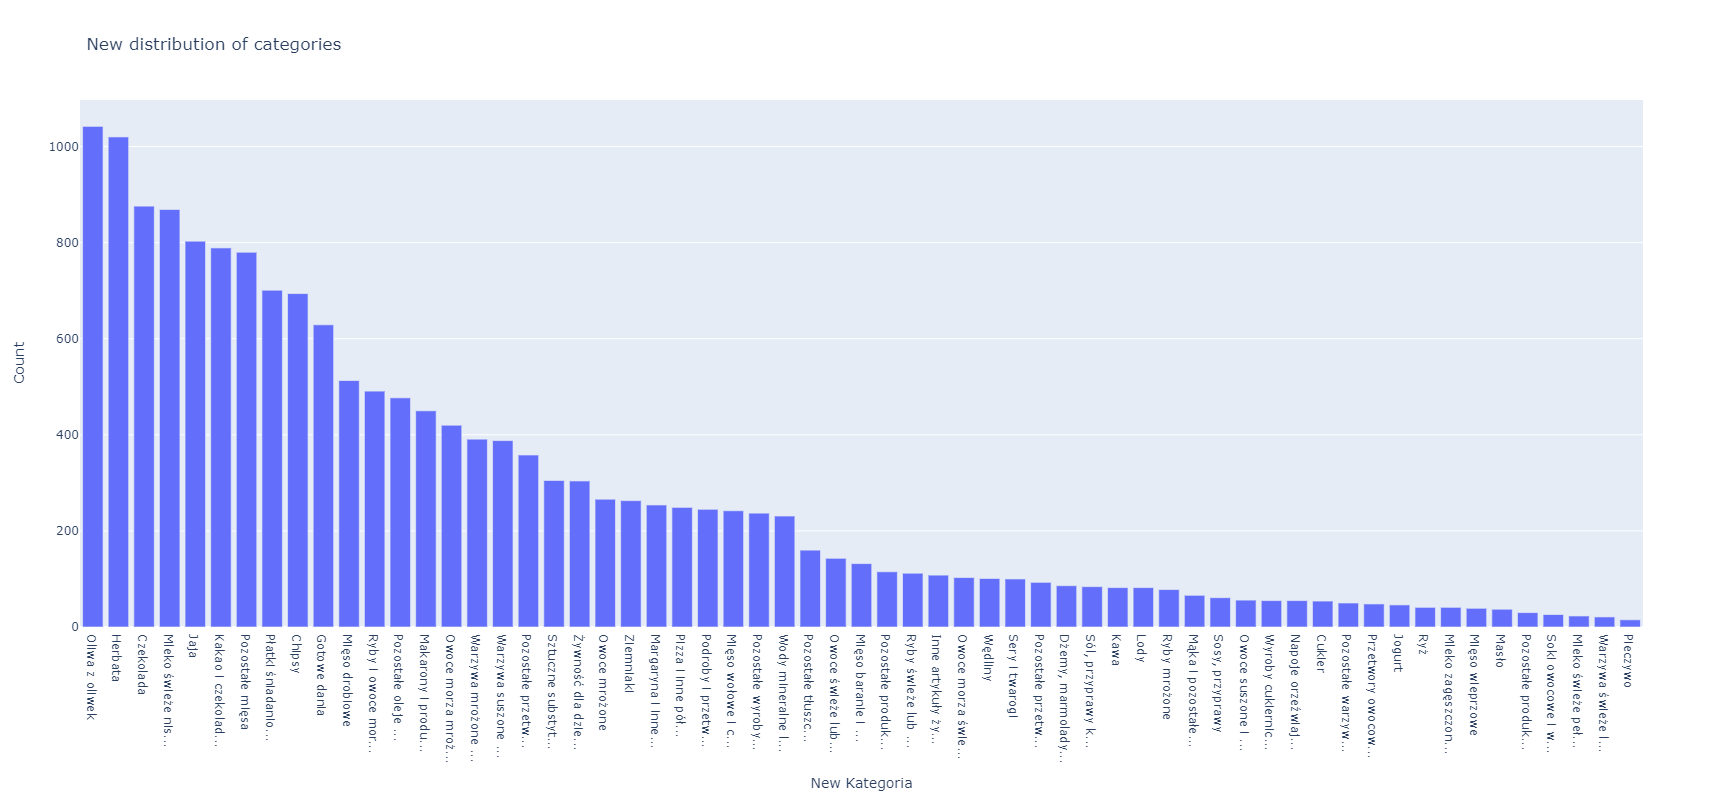

In [34]:
#Lets see the new distribution:

fig = px.bar({"Count": df["new kategoria"].value_counts().values, "New Kategoria": df["new kategoria"].value_counts().index}, x="New Kategoria", y="Count", title="New distribution of categories", barmode="group", height=800)

fig.update_xaxes(
  tickvals=df["new kategoria"].value_counts().index,
  ticktext=[s if len(s)<16 else s[0:16]+"..." for s in df["new kategoria"].value_counts().index]
)

fig.show()

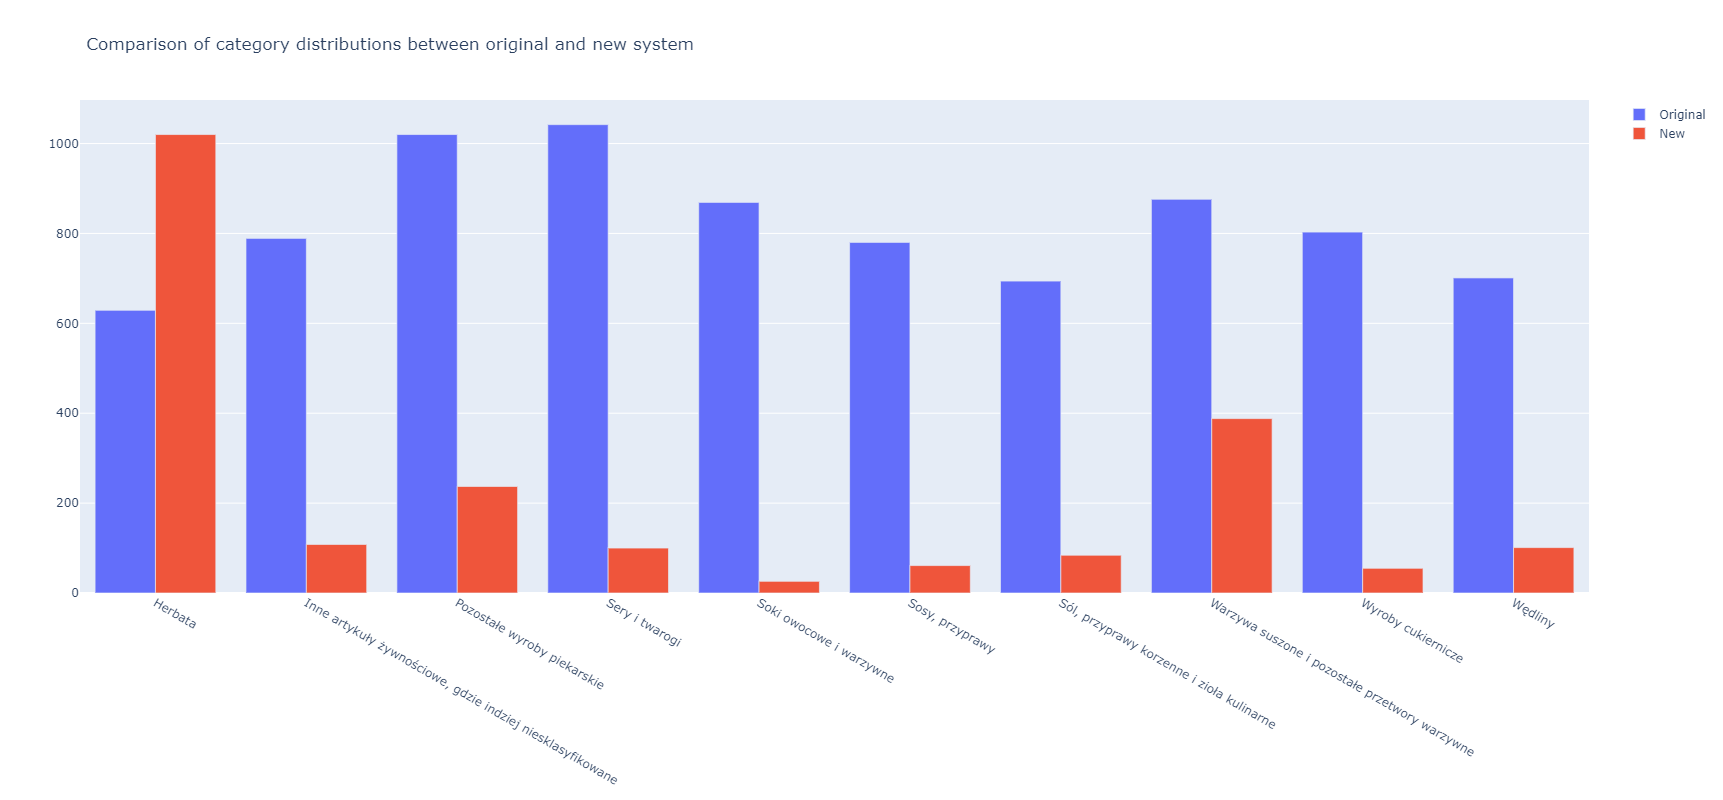

In [59]:
#Lets compare distributions between the two systems

import plotly.graph_objects as go
distribution_original = df["kategoria"].value_counts()[0:10].sort_index()
distribution_new = df[df["new kategoria"].isin(distribution_original.index.values)]["new kategoria"].value_counts().sort_index()
categories = distribution_original.index.values
fig = go.Figure(data=[
    go.Bar(name='Original', x=categories, y=distribution_original.values),
    go.Bar(name='New', x=categories, y=distribution_new.values)
])
fig.update_layout(barmode='group', height=800, title="Comparison of category distributions between original and new system")
fig.show()

In [60]:
#We can see the concept drift from the comparison chart above
#Let's verify the concept drift with the same algorithm we used previously:
#Building concept drift detector with the original category system:
concept_drift_detector = KSDrift(df[["kategoria"]].to_numpy(), p_val=0.05)

In [61]:
#Let's "predict" whether new category system introduces concept drift when compared to the original:
#As we can see, it does. As expected.
predictions = concept_drift_detector.predict(df[["new kategoria"]].to_numpy(), drift_type="batch", return_p_val=True, return_distance=True)
predictions

{'data': {'is_drift': 1,
  'distance': array([0.29500902], dtype=float32),
  'p_val': array([0.], dtype=float32),
  'threshold': 0.05},
 'meta': {'name': 'KSDrift', 'detector_type': 'offline', 'data_type': None}}